Image Classification Lab Related

Using ImageNet Dataset 

Transfer learning is used

In [1]:
# downloading files
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz


--2020-09-21 18:34:14--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.46.110
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.46.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  70.8MB/s    in 24s     

2020-09-21 18:34:39 (61.4 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



Extracting the tar.gz file 

In [6]:
import os
import tarfile

local_tar = '/content/imagenette2.tgz'

tar = tarfile.open(local_tar, "r:gz")
tar.extractall()
tar.close()

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# create a new generator
imagegen = ImageDataGenerator()
# load train data
train = imagegen.flow_from_directory("/content/imagenette2/train/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))
# load val data
val = imagegen.flow_from_directory("/content/imagenette2/val/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))


Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

# build a sequential model
model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=10, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# fit on data for 30 epochs
model.fit_generator(train, epochs=1, validation_data=val)


74/74 [==============================] - 641s 9s/step - loss: 2.5740 - accuracy: 0.1406 - val_loss: 3.0499 - val_accuracy: 0.1366


Using Transfer learning here now

In [13]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model = VGG16(include_top=False, weights='imagenet')
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
from keras.utils import to_categorical
# extract train and val features
vgg_features_train = pretrained_model.predict(train)
vgg_features_val = pretrained_model.predict(val)d

In [ ]:
# OHE target column
train_target = to_categorical(train.labels)
val_target = to_categorical(val.labels)

In [ ]:
model2 = Sequential()
model2.add(Flatten(input_shape=(7,7,512)))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(10, activation='softmax'))

# compile the model
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

model2.summary()

# train model using features generated from VGG16 model
model2.fit(vgg_features_train, train_target, epochs=50, batch_size=128, validation_data=(vgg_features_val, val_target))


Implementing from here

In [1]:
# downloading files
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz


--2020-09-22 15:21:52--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.37.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.37.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  73.2MB/s    in 23s     

2020-09-22 15:22:15 (64.7 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [2]:
import os
import tarfile

local_tar = '/content/imagenette2.tgz'

tar = tarfile.open(local_tar, "r:gz")
tar.extractall()
tar.close()

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

    
from tensorflow.keras.applications.inception_v3 import InceptionV3


local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-09-22 15:30:24--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  98.6MB/s    in 0.9s    

2020-09-22 15:30:26 (98.6 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [4]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/imagenette2/train/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/imagenette2/val/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)


Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [8]:
from tensorflow.keras.optimizers import RMSprop



# Flatten the output layer to 10 dimension classes
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (10, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x)

#model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=0.0001), metrics=['accuracy'])


In [9]:
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("ImageCLassifier.h5")


Epoch 1/25
20/20 [==============================] - 134s 7s/step - loss: 1.2551 - accuracy: 0.6087 - val_loss: 0.4405 - val_accuracy: 0.8624
Epoch 2/25
20/20 [==============================] - 130s 6s/step - loss: 0.5702 - accuracy: 0.8222 - val_loss: 0.3945 - val_accuracy: 0.8836
Epoch 3/25
20/20 [==============================] - 130s 6s/step - loss: 0.5281 - accuracy: 0.8294 - val_loss: 0.3353 - val_accuracy: 0.8783
Epoch 4/25
20/20 [==============================] - 130s 6s/step - loss: 0.4798 - accuracy: 0.8492 - val_loss: 0.3290 - val_accuracy: 0.8968
Epoch 5/25
20/20 [==============================] - 129s 6s/step - loss: 0.4292 - accuracy: 0.8615 - val_loss: 0.3993 - val_accuracy: 0.8677
Epoch 6/25
20/20 [==============================] - 130s 7s/step - loss: 0.4180 - accuracy: 0.8714 - val_loss: 0.3106 - val_accuracy: 0.9048
Epoch 7/25
20/20 [==============================] - 129s 6s/step - loss: 0.3917 - accuracy: 0.8718 - val_loss: 0.2962 - val_accuracy: 0.9074
Epoch 8/25
20

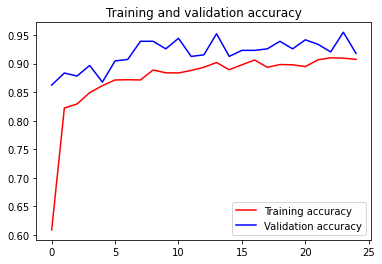

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [11]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving light-3176887_640.jpg to light-3176887_640.jpg
light-3176887_640.jpg
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


Loading the saved Model

In [ ]:
from tensorflow import keras
model = keras.models.load_model('path/to/location')

**Predicting the model directly with Preloaded Model**

In [ ]:
# example of using a pre-trained model as a classifier
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import  preprocess_input
from keras.applications.inception_v3 import  decode_predictions

# load an image from file
image = load_img('/content/dog.jpg', target_size=(299, 299))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)
# load the model
model = InceptionV3()
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))